This notebook walks through the preprocessing/QA workflow described in the course slides.

In [4]:
import os
try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'
print 'Using data from',datadir

%matplotlib inline

from nipype.interfaces import fsl
import nibabel
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from compute_fd_dvars import compute_fd,compute_dvars
from nipype.caching import Memory
mem = Memory(base_dir='.')

Using data from /home/vagrant/data


Load the data

In [2]:
subject='ses014'  

bolddir=os.path.join(datadir,'ds031/sub00001',subject,
        'functional')
boldfile=os.path.join(bolddir,'sub00001_ses014_task002_run001_bold.nii.gz')


Perform motion correction using FSL's mcflirt - this will take about a minute.

In [10]:
mcflirt = mem.cache(fsl.MCFLIRT)
mcflirt_results = mcflirt(in_file=boldfile,
                  save_plots=True,
                  mean_vol=True)
mcflirt_results.outputs

INFO:workflow:Executing node 39158ff31e7e5890e03f738b49a7c455 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/39158ff31e7e5890e03f738b49a7c455
INFO:workflow:Collecting precomputed outputs



mat_file = <undefined>
mean_img = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/39158ff31e7e5890e03f738b49a7c455/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg.nii.gz
out_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/39158ff31e7e5890e03f738b49a7c455/sub00001_ses014_task002_run001_bold_mcf.nii.gz
par_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/39158ff31e7e5890e03f738b49a7c455/sub00001_ses014_task002_run001_bold_mcf.nii.gz.par
rms_files = <undefined>
std_img = <undefined>
variance_img = <undefined>

Use FSL's BET to obtain the brain mask

In [13]:
bet = mem.cache(fsl.BET)
bet_results = bet(functional=True,
              in_file=mcflirt_results.outputs.mean_img,
              mask=True)
bet_results.outputs

INFO:workflow:Executing node fd8d3753ce941b1bf463367ccb438117 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/fd8d3753ce941b1bf463367ccb438117
INFO:workflow:Collecting precomputed outputs



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/fd8d3753ce941b1bf463367ccb438117/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/fd8d3753ce941b1bf463367ccb438117/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

Display the mean image, and show the outline of the brain mask.

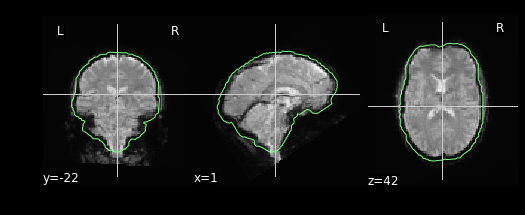

In [14]:
mask_display=nilearn.plotting.plot_epi(mcflirt_results.outputs.mean_img,cmap='gray')
mask_display.add_contours(bet_results.outputs.mask_file, levels=[.5])

Compute and plot the global signal within the mask across timepoints

In [17]:
maskdata=nibabel.load(bet_results.outputs.mask_file).get_data()
bolddata=nibabel.load(mcflirt_results.outputs.out_file).get_data()
maskvox=numpy.where(maskdata)
globalmean=numpy.zeros(bolddata.shape[3])
globalcv=numpy.zeros(bolddata.shape[3])
for t in range(bolddata.shape[3]):
    tmp=bolddata[:,:,:,t]
    globalmean[t]=numpy.mean(tmp[maskvox])
    globalcv[t]=numpy.std(tmp[maskvox])/numpy.mean(tmp[maskvox])

del bolddata


Load motion data and compute FD/DVARS

In [18]:
motiondata=numpy.loadtxt(mcflirt_results.outputs.par_file)
fd=compute_fd(motiondata)
dvars=compute_dvars(globalmean)

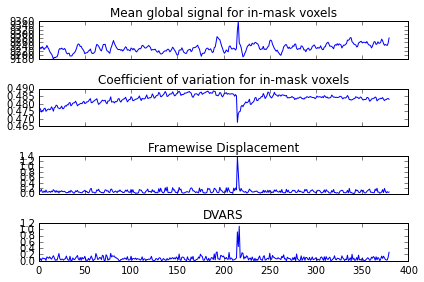

In [20]:
f, (ax1, ax2,ax3,ax4)=plt.subplots(4, sharex=True)
ax1.plot(globalmean)
ax1.set_title('Mean global signal for in-mask voxels')

ax2.plot(globalcv)
ax2.set_title('Coefficient of variation for in-mask voxels')

ax3.plot(fd)
ax3.set_title('Framewise Displacement')

ax4.plot(dvars)
ax4.set_title('DVARS')
plt.tight_layout()

Run independent components analysis on the data using MELODIC - this will take a few minutes.

In [23]:
melodic = mem.cache(fsl.MELODIC)
melodic_results = melodic(out_all=True,
                          report=True,
                          in_files=mcflirt_results.outputs.out_file,
                          mask=bet_results.outputs.mask_file)
melodic_results.outputs

INFO:workflow:Executing node 0500b548b6caedfb99100b8369c95926 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/0500b548b6caedfb99100b8369c95926
INFO:workflow:Collecting precomputed outputs



out_dir = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/0500b548b6caedfb99100b8369c95926
report_dir = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/0500b548b6caedfb99100b8369c95926/report

Load the ICA components and examine their correlation with the motion signals. For components with a correlation > 0.4, show the component voxels.

In [24]:
ica_comps=numpy.loadtxt(os.path.join(melodic_results.outputs.out_dir,'melodic_mix'))

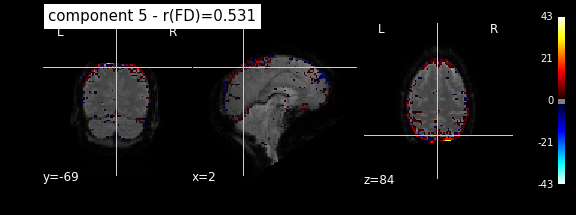

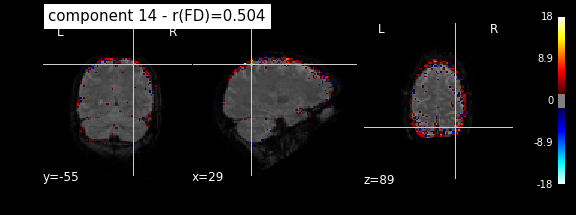

In [26]:
ica_motion_corr=numpy.zeros(ica_comps.shape[1])
for c in range(ica_comps.shape[1]):
    ica_motion_corr[c]=numpy.corrcoef(ica_comps[:,c],fd)[0,1]
    if abs(ica_motion_corr[c])>0.4:
        comp_img=nibabel.load(os.path.join(melodic_results.outputs.out_dir,'stats/thresh_zstat%d.nii.gz'%int(c+1)))
        nilearn.plotting.plot_stat_map(comp_img,mcflirt_results.outputs.mean_img,threshold=1.5,
               title='component %d - r(FD)=%0.3f'%(c+1,ica_motion_corr[c]))
        


Use fieldmap to perform distortion correction.  First we need to prepare the fieldmap; this will take a few minutes.


INFO:workflow:Executing node 8e99053e4a0a52d00606114ebae2c576 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8e99053e4a0a52d00606114ebae2c576
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node 2addb6da111f5e087e8e490b4b71517b in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/2addb6da111f5e087e8e490b4b71517b
INFO:workflow:Collecting precomputed outputs


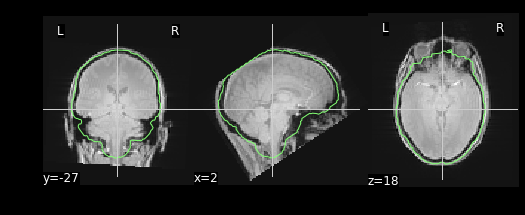

In [37]:
magfile=os.path.join(datadir,'ds031/sub00001',subject,
                'fieldmap/sub00001_ses014_001_magnitude.nii.gz')
roi = mem.cache(fsl.ExtractROI)
pick_first_mag = roi(in_file=magfile,
                           t_min=0,
                           t_size=1)

mag_bet_results = bet(functional=True,
                      in_file=pick_first_mag.outputs.roi_file,
                      mask=True)
mag_bet_results.outputs
mask_display=nilearn.plotting.plot_epi(pick_first_mag.outputs.roi_file,cmap='gray')
mask_display.add_contours(mag_bet_results.outputs.mask_file, levels=[.5])

INFO:workflow:Executing node 410ef879eea1181afbb0abe3e39c9304 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/410ef879eea1181afbb0abe3e39c9304
INFO:workflow:Running: bet /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8e99053e4a0a52d00606114ebae2c576/sub00001_ses014_001_magnitude_roi.nii.gz /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/410ef879eea1181afbb0abe3e39c9304/sub00001_ses014_001_magnitude_roi_brain.nii.gz -f 0.65 -F -m


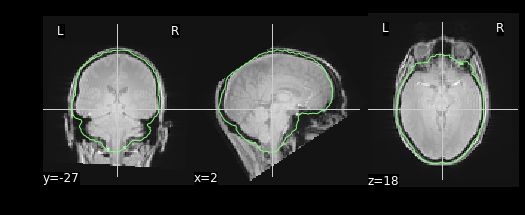

In [40]:
mag_bet_results = bet(functional=True,
                      in_file=pick_first_mag.outputs.roi_file,
                      mask=True,
                      frac=0.65)
mag_bet_results.outputs
mask_display=nilearn.plotting.plot_epi(pick_first_mag.outputs.roi_file,cmap='gray')
mask_display.add_contours(mag_bet_results.outputs.mask_file, levels=[.5])

In [42]:
prepare = mem.cache(fsl.PrepareFieldmap)
prepare_results = prepare(in_phase = os.path.join(datadir,'ds031/sub00001',subject,
                                                  'fieldmap/sub00001_ses014_001_phasediff.nii.gz'),
                          in_magnitude = mag_bet_results.outputs.out_file,
                          output_type = "NIFTI_GZ")
prepare_results.outputs

INFO:workflow:Executing node 73acd4df1f5c0b24076815f52d1b44a4 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-epi-PrepareFieldmap/73acd4df1f5c0b24076815f52d1b44a4
INFO:workflow:Collecting precomputed outputs



out_fieldmap = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-epi-PrepareFieldmap/73acd4df1f5c0b24076815f52d1b44a4/sub00001_ses014_001_phasediff_fslprepared.nii.gz

In [47]:
fugue = mem.cache(fsl.preprocess.FUGUE)
fugue_results = fugue(in_file = mcflirt_results.outputs.out_file,
                      fmap_in_file = prepare_results.outputs.out_fieldmap,
                      dwell_time = 2.6/10000.0,
                      unwarp_direction = 'y',
                      save_shift = True,
                      output_type = "NIFTI_GZ")
fugue_results.outputs

INFO:workflow:Executing node 98f9c2dfab388866cff9cb2962031f97 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-FUGUE/98f9c2dfab388866cff9cb2962031f97
INFO:workflow:Collecting precomputed outputs



fmap_out_file = <undefined>
shift_out_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-FUGUE/98f9c2dfab388866cff9cb2962031f97/sub00001_ses014_001_phasediff_fslprepared_vsm.nii.gz
unwarped_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-FUGUE/98f9c2dfab388866cff9cb2962031f97/sub00001_ses014_task002_run001_bold_mcf_unwarped.nii.gz
warped_file = <undefined>

Display difference between original and undistorted image

18725.5


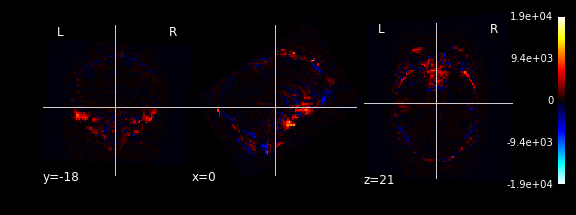

In [60]:

mcf_unwarped_mean_brain_img= nilearn.image.mean_img(fugue_results.outputs.unwarped_file)

meanbrainimg=nibabel.load(mcflirt_results.outputs.mean_img)

unwarp_diff=mcf_unwarped_mean_brain - meanbrainimg.get_data()
print numpy.max(unwarp_diff)
unwarp_diff_img=nibabel.Nifti1Image(unwarp_diff,meanbrainimg.get_affine())

fmap_display=nilearn.plotting.plot_stat_map(unwarp_diff_img,meanbrainimg)
del unwarp_diff_img


Perform spatial smoothing using Gaussian kernel

INFO:workflow:Executing node 31f61e653d005ed052d605d3c4f65a1a in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-utils-Smooth/31f61e653d005ed052d605d3c4f65a1a
INFO:workflow:Collecting precomputed outputs


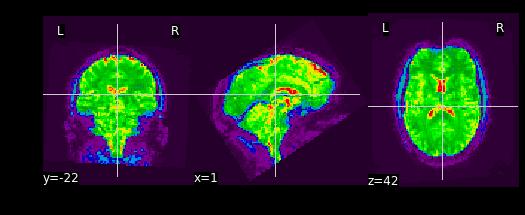

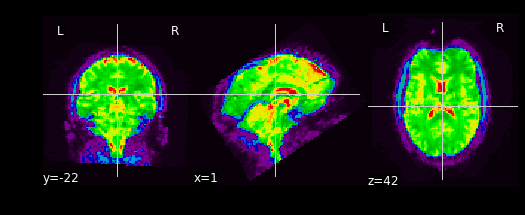

In [64]:
smooth=mem.cache(fsl.utils.Smooth)
smooth_results = smooth(fwhm=2.5,
                        in_file=fugue_results.outputs.unwarped_file)

nilearn.plotting.plot_epi(mcflirt_results.outputs.mean_img)
nilearn.plotting.plot_epi(nilearn.image.mean_img(smooth_results.outputs.smoothed_file))

High-pass filtering - this will take a few minutes

In [66]:
hpfilt = mem.cache(fsl.maths.TemporalFilter)
hpcutoff = 120
TR = 1.16
hpfilt_results = hpfilt(highpass_sigma = hpcutoff/TR,
                        in_file=smooth_results.outputs.smoothed_file)

binarymaths = mem.cache(fsl.maths.BinaryMaths)
rescale_results = binarymaths(operation = 'add', 
                              in_file=hpfilt_results.outputs.out_file,
                              operand_file=mcflirt_results.outputs.mean_img
                              )

INFO:workflow:Executing node a607cbabaeb8d43b3794dc08e1de13cc in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-TemporalFilter/a607cbabaeb8d43b3794dc08e1de13cc
INFO:workflow:Running: fslmaths /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-utils-Smooth/31f61e653d005ed052d605d3c4f65a1a/sub00001_ses014_task002_run001_bold_mcf_unwarped_smooth.nii.gz -bptf 103.448276 -1.000000 /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-TemporalFilter/a607cbabaeb8d43b3794dc08e1de13cc/sub00001_ses014_task002_run001_bold_mcf_unwarped_smooth_filt.nii.gz
INFO:workflow:Executing node 62eef905261f55c40196ca4522d075d1 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-BinaryMaths/62eef905261f55c40196ca4522d075d1
INFO:workflow:Running: fslmaths /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fs

Exercise: Plot the power spectrum for a voxel to look at the effects of filtering

In [ ]:
# mask using gray matter mask
hpfilt=fsl.ImageMaths(suffix='_masked')
hpfilt.inputs.op_string = '-mul'
hpfilt.inputs.in_file=mcf_boldfile.replace('.nii.gz','_unwarped_smoothed_hpf.nii.gz')
hpfilt.inputs.in_file2=os.path.join(bolddir,'gray_matter_mask_bin.nii.gz')
hpfilt.inputs.out_file=mcf_boldfile.replace('.nii.gz','_unwarped_smoothed_hpf_rescaled_masked.nii.gz')
if not os.path.exists(mcf_boldfile.replace('.nii.gz','_unwarped_smoothed_hpf_rescaled_masked.nii.gz')):
    hpfilt.run()